<a href="https://colab.research.google.com/github/beerbear4369/bitcoinprice/blob/master/trend_prediction_20200822_v1_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Import the necessary libraries**
---

In [186]:
!pip install xlsxwriter
# import h5py
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import xlsxwriter

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from io import BytesIO

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.3.0
numpy:       1.18.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


## **3. Set matplotlib to have seaborn plot style**
---

In [3]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **4. Create makeSteps function**
---

In [5]:
def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)
    
                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)
    
    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]
        
    return segments

print(makeSteps)

<function makeSteps at 0x7f595100c840>


## **5. Load bitcoin price data**
---
* Step 1: Load the csv file and extract the values
* Step 2: Convert the data and label into numpy arrays
* Step 3: Inspect the shape and data type of the 'close_price' and 'label' arrays

In [6]:

f = pd.read_csv('/content/gdrive/My Drive/iss/PR_grpproject/data/BTCUSDT-1d-data_all_features_labbeled.csv')
# print(f,f.dtypes)
X_c        = f["close"]
X_v        = f["volume"]

Y=f["Trix next 7 day(1 for up 0 for down)"]
# to make close price and volum as the X array                                                                             
X_c    = np.array(X_c)
X_v    = np.array(X_v)  
X=np.vstack([X_c,X_v])                                                         
Y   = np.array(Y)
Y=Y[43:1089]

print(X,X.dtype,X.shape[0])
print(Y,Y.dtype,Y.shape[0])

# to transfer the input to a segment of 44 days
length       = 44
dist         = 1
XS=makeSteps(X,44,1)
# print(XS,'The shape of XS is', XS.shape, "and the type is", XS.dtype) 
close=XS[0,:,:] 
volume=XS[1,:,:] 

print('The shape of close is', close.shape, "and the type is", close.dtype)   
print('The shape of volume is', volume.shape, "and the type is", volume.dtype)                                                                        

[[ 4285.08      4108.37      4139.98     ... 11594.23     11761.41
  11673.39    ]
 [  795.150377  1199.888264   381.309763 ... 65755.92602  41858.16104
  13595.24545 ]] float64 2
[0. 0. 0. ... 1. 1. 0.] float64 1046
The shape of close is (1046, 44) and the type is float64
The shape of volume is (1046, 44) and the type is float64


## **7. Prepare data for training and testing**
---
* Step 1: Split the dataset into training and testing
* Step 2: Generate segments for each signal
* Step 3: Consolidate the arrays
* Step 4: Inspect the data shape and type

In [174]:
                                                                                # Step 1
# trNor        = nor[0:28800].copy()
# tsNor        = nor[28800:32000].copy()
# trCad        = cad[0:5000].copy()
# tsCad        = cad[5000:6120].copy()

## generate segments
length       = 21
dist         = 1
closeS=makeSteps(close,length,dist)                                               # Step 2
# print('The shape of closeS is', closeS.shape, "and the type is",closeS.dtype)

## seperate training and testing dataset
trDat=closeS[0:867,:,:]
tsDat=closeS[867:,:,:]
trLbl=np.reshape(Y[0:867],(-1,1))
tsLbl=np.reshape(Y[867:],(-1,1))
# trNorS       = makeSteps(trNor, length, dist)
# tsNorS       = makeSteps(tsNor, length, dist)
# trCadS       = makeSteps(trCad, length, dist)
# tsCadS       = makeSteps(tsCad, length, dist)

#                                                                                 # Step 3
# trDat        = np.vstack([trNorS,trCadS])
# tsDat        = np.vstack([tsNorS,tsCadS])

# trLbl        = np.vstack([np.zeros([trNorS.shape[0],1]),
#                           np.ones([trCadS.shape[0],1])])
# tsLbl        = np.vstack([np.zeros([tsNorS.shape[0],1]),
#                           np.ones([tsCadS.shape[0],1])])

print('The shape of trDat is', trDat.shape, "and the type is", trDat.dtype)
print('The shape of trLbl is', trLbl.shape, "and the type is", trLbl.dtype)
print('The shape of tsDat is', tsDat.shape, "and the type is", tsDat.dtype)
print('The shape of tsLbl is', tsLbl.shape, "and the type is", tsLbl.dtype)

The shape of trDat is (867, 24, 21) and the type is float64
The shape of trLbl is (867, 1) and the type is float64
The shape of tsDat is (179, 24, 21) and the type is float64
The shape of tsLbl is (179, 1) and the type is float64


## **8. Define the NN model**
___
* Step 1: Set a name for the coming model (required for saving)
* Step 2: Define the NN model (to be completed)
* Step 3: Create models for training and testing
* Step 4: Display the summary of the model of interest 

In [254]:
modelname   = 'tp_Conv2D_LSTM_v8.13'
optmz       = optimizers.Adam(lr=0.00001)                                                         # Step 1
lognote=modelname+' step length='+str(length)+" dist="+str(dist)+" lr=0.0001"+".study the impact of learning rate, make it converge "
print(lognote)
                                                                                # Step 2
def createModel():        
    inputs= Input(shape=(trDat.shape[1],length))

    y = Conv1D(32, 5, activation='relu')(inputs)
    # y = Dropout(0.25)(y)
    # y = Conv1D(32, 5, activation='relu')(y)
    # y = MaxPooling1D(2)(y)
    # y = Conv1D(48, 5, activation='relu')(y)
    # y = Dropout(0.5)(y)
    # y = Conv1D(48, 5, activation='relu')(y)
    # y = MaxPooling1D(2)(y)
    # y = Conv1D(64, 5, activation='relu')(y)
    # y = Dropout(0.5)(y)
    # y = Conv1D(64, 5, activation='relu')(y)
    # y = MaxPooling1D(2)(y)

  
    # y = LSTM(32,return_sequences=True,dropout=0.25,recurrent_dropout=0.25)(y)
    # y = LSTM(32,return_sequences=True,dropout=0.5,recurrent_dropout=0.25)(y)
    # y = LSTM(32,return_sequences=True,dropout=0.25)(y)
    # y = LSTM(64, dropout=0.25)(y)

    y = LSTM(32,return_sequences=True)(y)
    y = LSTM(64)(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='binary_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])

    return model

                                                                                # Step 3
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 4

tp_Conv2D_LSTM_v8.13 step length=21 dist=1 lr=0.0001.study the impact of learning rate, make it converge 
Model: "functional_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 24, 21)]          0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 20, 32)            3392      
_________________________________________________________________
lstm_145 (LSTM)              (None, 20, 32)            8320      
_________________________________________________________________
lstm_146 (LSTM)              (None, 64)                24832     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 65        
Total params: 36,609
Trainable params: 36,609
Non-trainable params: 0
_________________________________________________________________


## **9. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callback objects into a list

In [255]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/PR_grpproject/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')


Callbacks created:

Path to model: /content/gdrive/My Drive/iss/PR_grpproject/tp_Conv2D_LSTM_v8.13.hdf5
Path to log:   /content/gdrive/My Drive/iss/PR_grpproject/tp_Conv2D_LSTM_v8.13.csv


## **10. Train the deep learning model**
___

In [256]:
model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
          epochs=100, 
          batch_size=64,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/100
14/14 [==============================] - 1s 85ms/step - loss: 0.6962 - accuracy: 0.5063 - val_loss: 0.7066 - val_accuracy: 0.4078
Epoch 2/100
14/14 [==============================] - 0s 29ms/step - loss: 0.6932 - accuracy: 0.5329 - val_loss: 0.7064 - val_accuracy: 0.4078
Epoch 3/100
14/14 [==============================] - 0s 28ms/step - loss: 0.6913 - accuracy: 0.5363 - val_loss: 0.7062 - val_accuracy: 0.4078
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 0.6895 - accuracy: 0.5467 - val_loss: 0.7068 - val_accuracy: 0.4078
Epoch 5/100
14/14 [==============================] - 0s 28ms/step - loss: 0.6870 - accuracy: 0.5606 - val_loss: 0.7055 - val_accuracy: 0.4078
Epoch 6/100
14/14 [==============================] - 0s 27ms/step - loss: 0.6841 - accuracy: 0.5709 - val_loss: 0.7046 - val_accuracy: 0.4078
Epoch 7/100
14/14 [==============================] - 0s 29ms/step - loss: 0.6820 - accuracy: 0.5744 - val_loss: 0.7045 - val_accuracy: 0.4078
Epoch 

## **11. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [257]:
                                                                                # Step 1
modelGo.load_weights(filepath)
print("Model weights loaded from:", filepath)

modelGo.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                           # Step 2
print("Prediction completes.")

Model weights loaded from: /content/gdrive/My Drive/iss/PR_grpproject/tp_Conv2D_LSTM_v8.13.hdf5
Prediction completes.


## **12. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Calculate the accuracy score
* Step 3: Generate classification report

In [258]:
                                                                                # Step 1
labelname   = ['uptrend',          # The label for reporting metrics
               'downtrend']
                                                                                
testScores  = metrics.accuracy_score(tsLbl,predicts.round())                    # Step 2
              
                                                                                # Step 3
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(tsLbl,
                                    predicts.round(),
                                    target_names=labelname,
                                    digits=4))



Best accuracy (on testing dataset): 83.24%
              precision    recall  f1-score   support

     uptrend     0.7529    0.8767    0.8101        73
   downtrend     0.9043    0.8019    0.8500       106

    accuracy                         0.8324       179
   macro avg     0.8286    0.8393    0.8301       179
weighted avg     0.8425    0.8324    0.8337       179



## **13. Print confusion matrix**
---

In [259]:
confusion   = metrics.confusion_matrix(tsLbl,predicts.round())    
print(confusion)

[[64  9]
 [21 85]]


## **14. Plot curves on validation loss and accuracy**
---

    epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.506344  0.696244      0.407821  0.706587
1       1  0.532872  0.693239      0.407821  0.706401
2       2  0.536332  0.691330      0.407821  0.706246
3       3  0.546713  0.689500      0.407821  0.706760
4       4  0.560554  0.686997      0.407821  0.705534
..    ...       ...       ...           ...       ...
95     95  0.771626  0.451411      0.821229  0.452774
96     96  0.777393  0.449290      0.804469  0.453220
97     97  0.776240  0.448310      0.821229  0.460590
98     98  0.772780  0.447633      0.810056  0.451822
99     99  0.770473  0.447697      0.798883  0.453406

[100 rows x 5 columns]


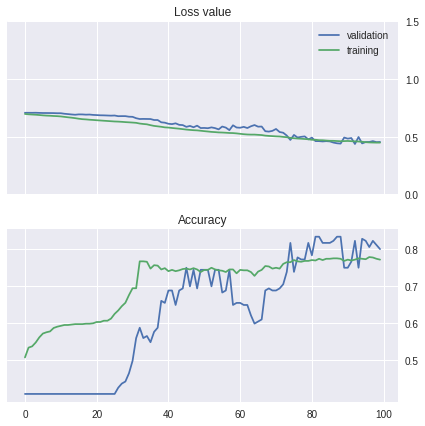

In [260]:
records     = pd.read_csv(folderpath+modelname +'.csv')
print(records)
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()

plt.savefig(folderpath+modelname+'_loss and accuracy.png')
plt.show()


## **15. Save the model plot**
---

In [261]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/PR_grpproject/tp_Conv2D_LSTM_v8.13_plot.png


## **16. Auto save model performance to a excel**

In [262]:
# 创建一个新Excel文件并添加一个工作表。
workbook = xlsxwriter.Workbook((folderpath+'log/'+modelname+'training_log.xlsx'))
worksheet = workbook.add_worksheet()
worksheet.name=modelname
# 加宽第一列使文本更清晰。
worksheet.set_column('A:A', 30)
 
# 插入一张图片。
worksheet.write('B1', lognote)
worksheet.insert_image('B2', (folderpath+modelname+'_plot.png'))
worksheet.insert_image('H2', (folderpath+modelname+'_loss and accuracy.png'))
worksheet.write("S2",metrics.classification_report(tsLbl,
                                    predicts.round(),
                                    target_names=labelname,
                                    digits=4))
# # 插入一张位偏移图片。
# worksheet.write('A12', '插入一张位偏移图片：')
# worksheet.insert_image('B12', 'python.png', {'x_offset': 15, 'y_offset': 10})
 
# # 插入一张缩放了的图片。
# worksheet.write('A23', '插入一张缩放了的图片：')
# worksheet.insert_image('B23', 'python.png', {'x_scale': 0.5, 'y_scale': 0.5})
workbook.close()